<a href="https://colab.research.google.com/github/safeai-snu/TimeSeriesAI/blob/main/ch1/ch1_3_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

본 실습은 Marco Peixeiro의 Time Series Forecasting in Python 책과 코드를 참조해 만들어졌습니다. 본 코드는
https://github.com/jpub-dongdong9/TimeSeriesForecastingInPython/tree/master
에서도 찾을 수 있습니다.

In [1]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
print(tf.__version__)

2.17.0


In [4]:
tf.random.set_seed(42)
np.random.seed(42)

In [5]:
train_df = pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/train.csv', index_col=0)
val_df =  pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/val.csv', index_col=0)
test_df =  pd.read_csv('https://raw.githubusercontent.com/safeai-snu/TimeSeriesAI/main/dataset/ch1/test.csv', index_col=0)

print(train_df.shape, val_df.shape, test_df.shape)

(12285, 5) (3510, 5) (1756, 5)


In [6]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [7]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [8]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

## LSTM

### Single-step model

In [9]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['traffic_volume'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['traffic_volume'])

In [10]:
mae_val = [0.083, 0.068, 0.033]
mae_test = [0.081, 0.068, 0.029]

In [11]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance = {}
performance = {}

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 0.0529 - mean_absolute_error: 0.1671 - val_loss: 0.0095 - val_mean_absolute_error: 0.0706
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0076 - mean_absolute_error: 0.0626 - val_loss: 0.0044 - val_mean_absolute_error: 0.0482
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0045 - mean_absolute_error: 0.0481 - val_loss: 0.0036 - val_mean_absolute_error: 0.0430
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0039 - mean_absolute_error: 0.0440 - val_loss: 0.0033 - val_mean_absolute_error: 0.0415
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0035 - mean_absolute_error: 0.0416 - val_loss: 0.0030 - val_mean_absolute_error: 0.0393
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 0.0032 - mean_absolute_error: 0.0390 - val_loss: 0.0027 - val_mean_absolute_error: 0.0367
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - loss: 0.0030 - mean_absolute_error

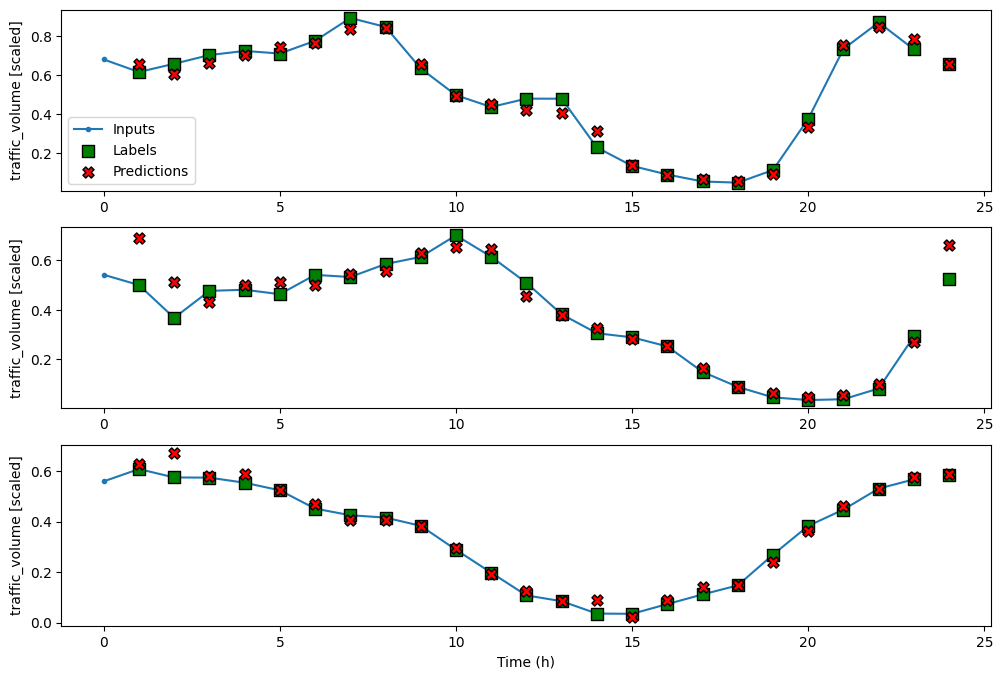

In [12]:
wide_window.plot(lstm_model)

plt.savefig('./CH1_F09_peixeiro.png', dpi=300)

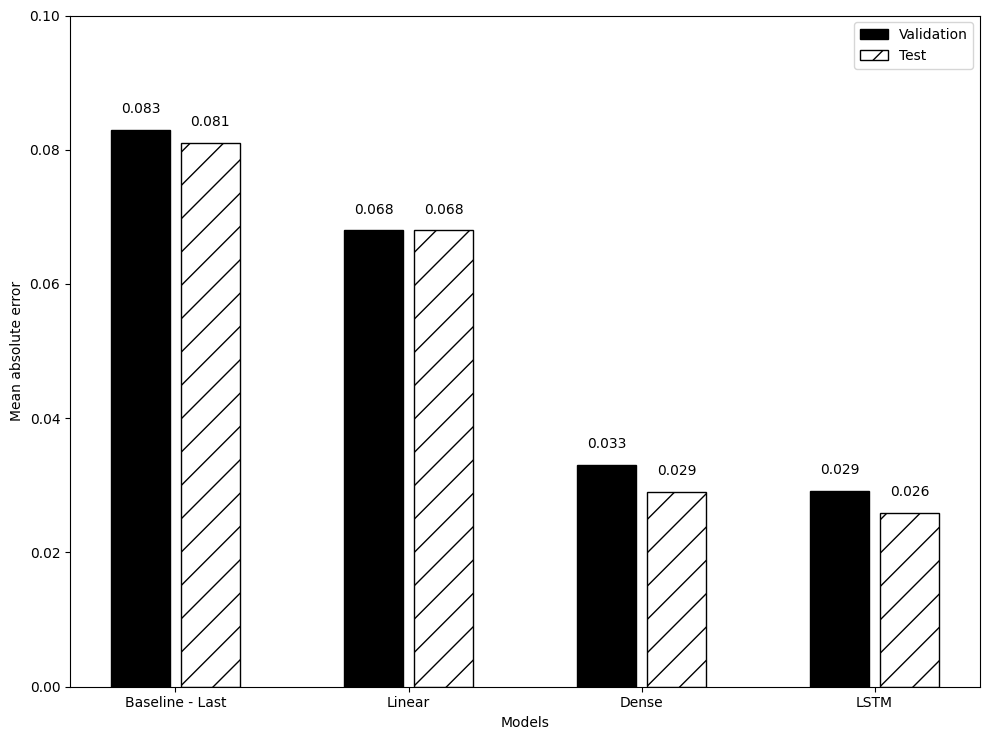

In [13]:
mae_val.append(val_performance['LSTM'][1])
mae_test.append(performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1_F10_peixeiro.png', dpi=300)

### Multi-step model

In [14]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['traffic_volume'])

In [15]:
# Values obtained from other model (baseline)

ms_mae_val = [0.352, 0.347, 0.088, 0.078]
ms_mae_test = [0.347, 0.341, 0.076, 0.064]

In [16]:
ms_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_lstm_model, multi_window)

ms_val_performance = {}
ms_performance = {}

ms_val_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.val)
ms_performance['LSTM'] = ms_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0945 - mean_absolute_error: 0.2346 - val_loss: 0.0205 - val_mean_absolute_error: 0.1010
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - loss: 0.0174 - mean_absolute_error: 0.0924 - val_loss: 0.0172 - val_mean_absolute_error: 0.0879
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0152 - mean_absolute_error: 0.0831 - val_loss: 0.0173 - val_mean_absolute_error: 0.0920
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0145 - mean_absolute_error: 0.0804 - val_loss: 0.0161 - val_mean_absolute_error: 0.0828
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0141 - mean_absolute_error: 0.0788 - val_loss: 0.0159 - val_mean_absolute_error: 0.0828
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0139 - mean_absolute_error: 0.0779 - val_loss: 0.0162 - val_mean_absolute_error: 0.0876
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - loss: 0.0137 - mean_absolute_error: 0.

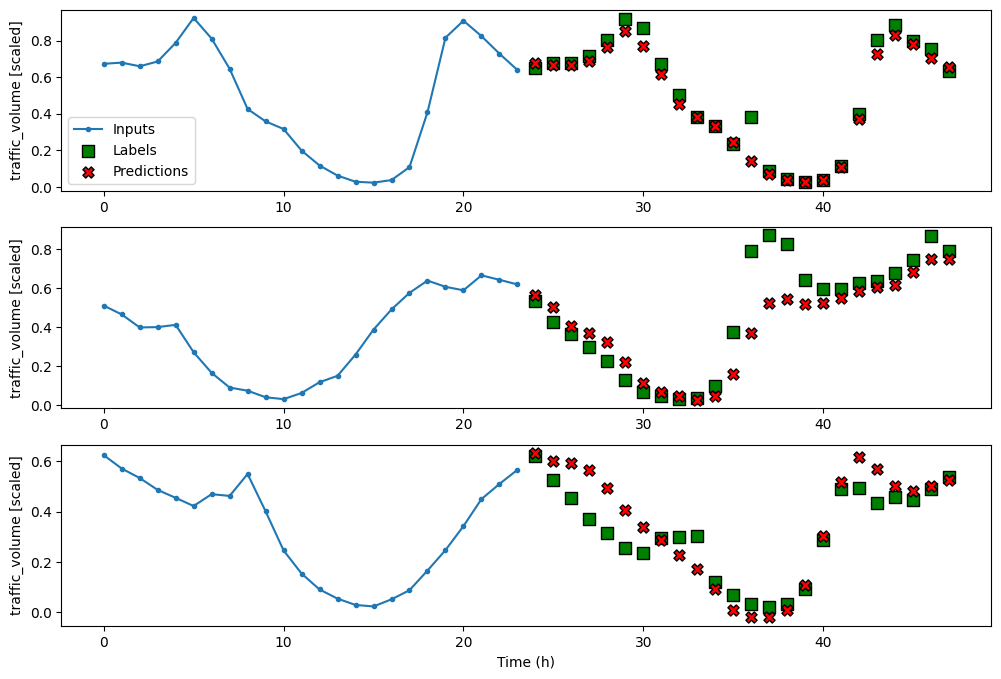

In [17]:
multi_window.plot(ms_lstm_model)

plt.savefig('./CH1_F11_peixeiro.png', dpi=300)

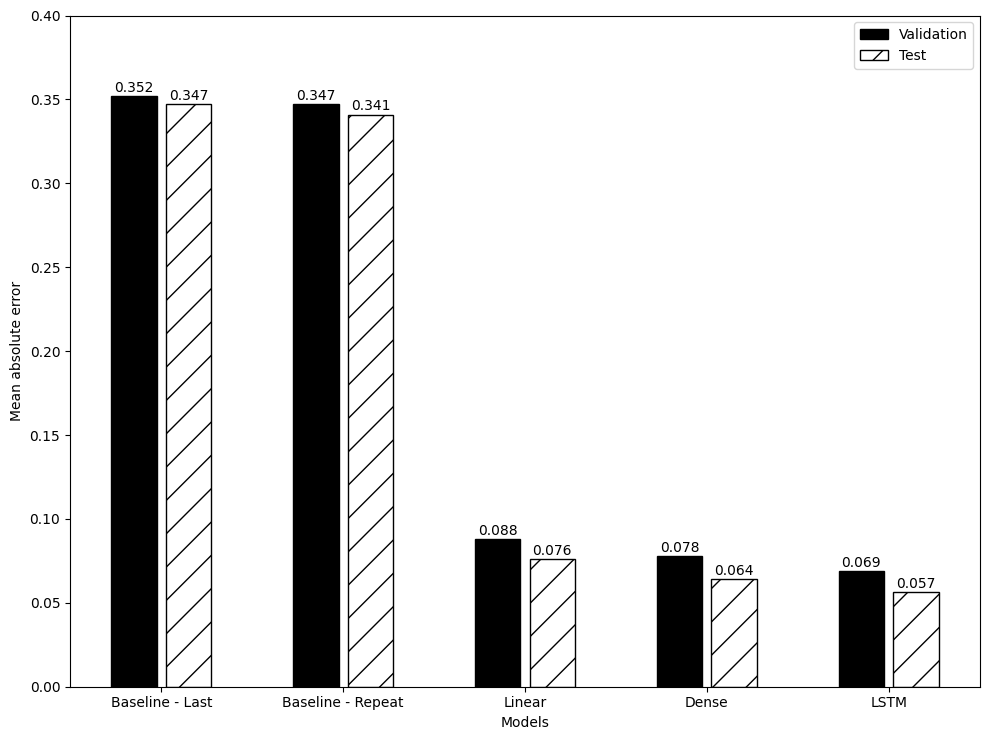

In [18]:
ms_mae_val.append(ms_val_performance['LSTM'][1])
ms_mae_test.append(ms_performance['LSTM'][1])

x = np.arange(5)

labels = ['Baseline - Last', 'Baseline - Repeat', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1_F12_peixeiro.png', dpi=300)

### Multi-output model

In [19]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['temp','traffic_volume'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['temp','traffic_volume'])

In [20]:
# Values obtained from other model (baseline)

mo_mae_val = [0.048, 0.039, 0.023]
mo_mae_test = [0.047, 0.036, 0.020]

In [21]:
mo_lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units = 2)
])

history = compile_and_fit(mo_lstm_model, mo_wide_window)

mo_val_performance = {}
mo_performance = {}

mo_val_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.val)
mo_performance['LSTM'] = mo_lstm_model.evaluate(mo_wide_window.test, verbose=0)

Epoch 1/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.0920 - mean_absolute_error: 0.2105 - val_loss: 0.0114 - val_mean_absolute_error: 0.0695
Epoch 2/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0085 - mean_absolute_error: 0.0606 - val_loss: 0.0052 - val_mean_absolute_error: 0.0469
Epoch 3/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0046 - mean_absolute_error: 0.0437 - val_loss: 0.0033 - val_mean_absolute_error: 0.0367
Epoch 4/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0364 - val_loss: 0.0026 - val_mean_absolute_error: 0.0328
Epoch 5/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0028 - mean_absolute_error: 0.0331 - val_loss: 0.0022 - val_mean_absolute_error: 0.0303
Epoch 6/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 0.0025 - mean_absolute_error: 0.0310 - val_loss: 0.0020 - val_mean_absolute_error: 0.0289
Epoch 7/50
384/384 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0023 - mean_absolute_error: 0

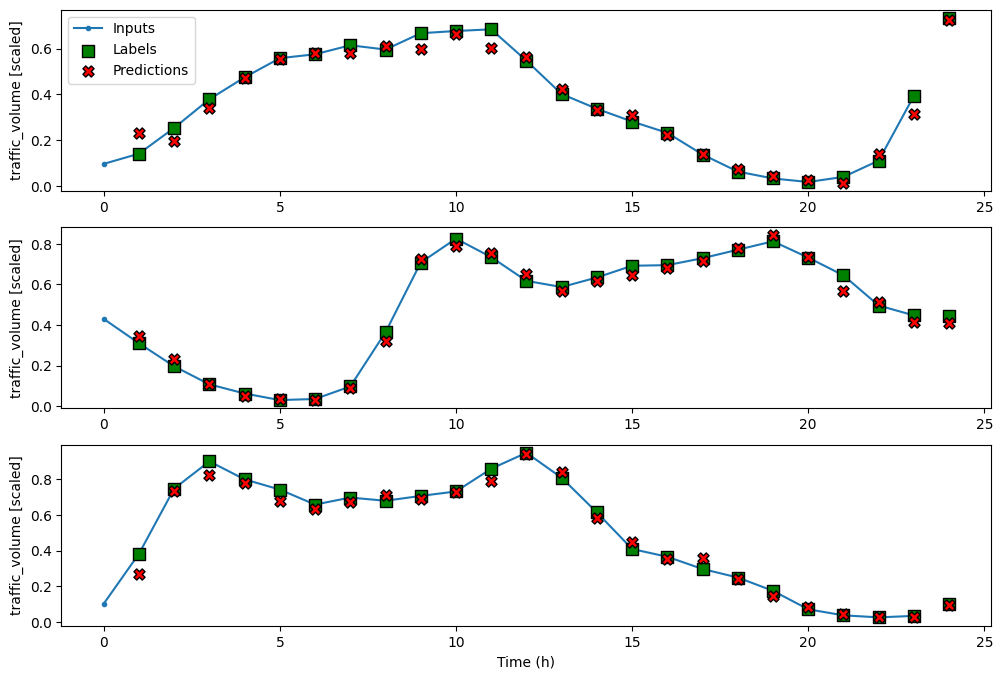

In [22]:
mo_wide_window.plot(mo_lstm_model)

plt.savefig('./CH1_F13_peixeiro.png', dpi=300)

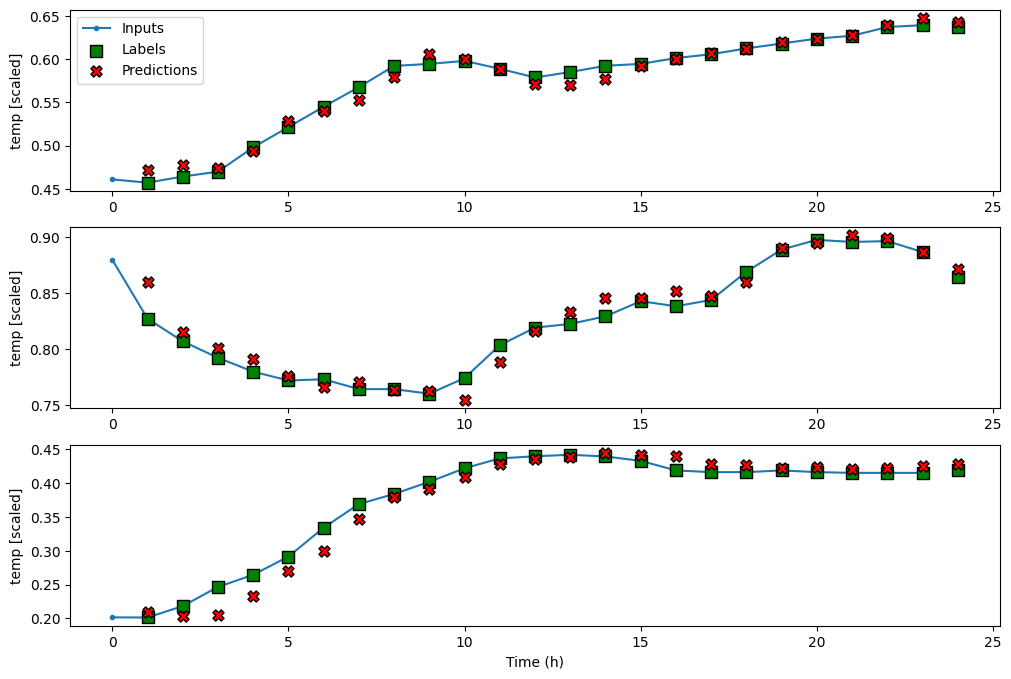

In [23]:
mo_wide_window.plot(model=mo_lstm_model, plot_col='temp')

plt.savefig('./CH1_F14_peixeiro.png', dpi=300)

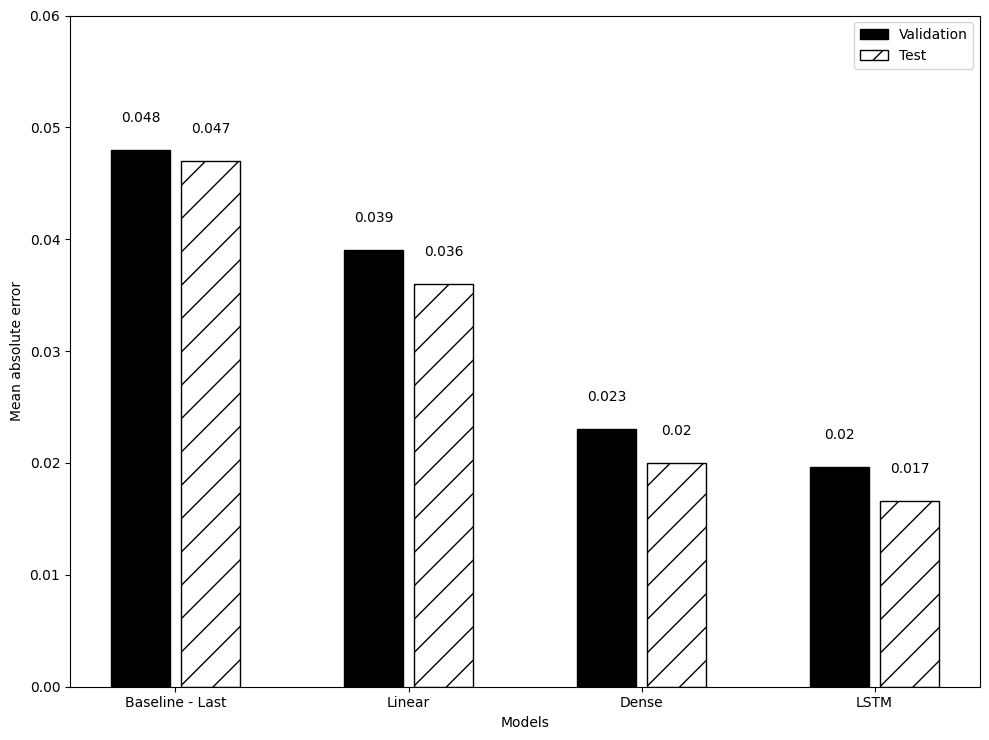

In [24]:
mo_mae_val.append(mo_val_performance['LSTM'][1])
mo_mae_test.append(mo_performance['LSTM'][1])

x = np.arange(4)

labels = ['Baseline - Last', 'Linear', 'Dense', 'LSTM']

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=labels)
plt.legend(loc='best')
plt.tight_layout()

plt.savefig('./CH1_F15_peixeiro.png', dpi=300)